In [1]:
import pickle

with open('spike_recorded_test2.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [2]:
data

{'index': array([71, 49, 27, 61, 34, 72,  4, 17, 73, 60, 80, 14, 48,  4,  2, 62, 38,
        26, 30, 14, 72, 26, 12, 79, 55, 73, 83, 37, 76, 24,  3,  4, 33, 57,
        80,  7,  6, 73, 14, 72, 36, 26,  2, 11, 59, 82, 16, 44, 64, 28, 55,
        77, 53, 30, 26, 51, 69, 83, 40, 37, 57, 11, 73, 74, 84, 61, 78, 64,
        66, 24, 45, 14, 37, 68, 15, 64, 10, 36, 21, 22, 53, 44,  0, 41, 22,
        41, 63, 21,  5, 66, 71, 82, 82, 81, 13, 22,  8, 30, 50, 60, 41, 63,
        61, 60,  7,  6, 38, 78, 67, 66, 57, 83, 56, 48, 19, 29, 40, 26, 49,
         0, 48, 46, 33, 32, 27, 15, 26, 20, 13, 37, 43, 18, 53, 83, 46, 29,
        29, 12, 83, 50, 26, 46,  5, 72, 71, 48, 75, 25, 61, 68, 73, 67, 60,
         5, 17, 22, 66, 62, 73, 27, 33, 51, 83, 16, 55,  7,  6,  2,  5,  0,
        26, 43, 24,  4, 56, 28, 76,  5, 49, 19, 39,  8, 76, 82,  4, 29, 66,
        53,  7, 16, 79, 14, 12, 80, 46, 74, 12, 70, 17, 20, 36, 19, 84, 37,
        35, 47, 18,  7, 26, 63, 70, 53,  7, 27, 52,  7, 15, 35, 48, 24, 44,
   

In [3]:
import brian2 as b2

In [4]:
spikes_t = data['sp_time']*b2.second

In [5]:
spikes_i = data['index']

In [6]:
num_neuron = len(set(spikes_i))

In [7]:
num_neuron

84

In [8]:
SGG = b2.SpikeGeneratorGroup(num_neuron+1, spikes_i, spikes_t)

Basic setup 을 취한다. 

In [9]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
import numpy.random as rnd
from neurodynex3.tools import plot_tools
import numpy
import matplotlib.pyplot as plt
from math import floor
import time

b2.defaultclock.dt = 0.10 * b2.ms

In [10]:
b2.start_scope()



In [11]:
N_Excit=384
N_Inhib=96
weight_scaling_factor=5.33
t_stimulus_start=100 * b2.ms 
t_stimulus_duration=9999 * b2.ms
coherence_level=0.
stimulus_update_interval=30 * b2.ms
mu0_mean_stimulus_Hz=250.
stimulus_std_Hz=20.
N_extern=1000
firing_rate_extern=9.8 * b2.Hz
w_pos=100.90
f_Subpop_size=0.25  # .15 in publication [1]
max_sim_time=1000. * b2.ms 
stop_condition_rate=None
monitored_subset_size=512 
E_leak_excit = -70.0 * b2.mV


In [12]:
N_Excit=341 
N_Inhib=85

In [13]:
print("simulating {} neurons. Start: {}".format(N_Excit + N_Inhib, time.ctime()))
t_stimulus_end = t_stimulus_start + t_stimulus_duration

N_Group_A = int(N_Excit * f_Subpop_size)  # size of the excitatory subpopulation sensitive to stimulus A
N_Group_B = N_Group_A  # size of the excitatory subpopulation sensitive to stimulus B
N_Group_Z = N_Excit - N_Group_A - N_Group_B  # (1-2f)Ne excitatory neurons do not respond to either stimulus.

Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons
G_leak_excit = 25.0 * b2.nS  # leak conductance
E_leak_excit = -70.0 * b2.mV  # reversal potential
v_spike_thr_excit = -50.0 * b2.mV  # spike condition
v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
t_abs_refract_excit = 2. * b2.ms  # absolute refractory period

# specify the inhibitory interneurons:
# N_Inhib = 200
Cm_inhib = 0.2 * b2.nF
G_leak_inhib = 20.0 * b2.nS
E_leak_inhib = -70.0 * b2.mV
v_spike_thr_inhib = -50.0 * b2.mV
v_reset_inhib = -60.0 * b2.mV
t_abs_refract_inhib = 1.0 * b2.ms

# specify the AMPA synapses
E_AMPA = 0.0 * b2.mV
tau_AMPA = 2.5 * b2.ms

# specify the GABA synapses
E_GABA = -70.0 * b2.mV
tau_GABA = 5.0 * b2.ms

# specify the NMDA synapses
E_NMDA = 0.0 * b2.mV
tau_NMDA_s = 100.0 * b2.ms
tau_NMDA_x = 2. * b2.ms
alpha_NMDA = 0.5 * b2.kHz

# projections from the external population
g_AMPA_extern2inhib = 1.62 * b2.nS
g_AMPA_extern2excit = 2.1 * b2.nS

# projectsions from the inhibitory populations
g_GABA_inhib2inhib = weight_scaling_factor * 1.25 * b2.nS
g_GABA_inhib2excit = weight_scaling_factor * 1.60 * b2.nS

# projections from the excitatory population
g_AMPA_excit2excit = weight_scaling_factor * 0.012 * b2.nS
g_AMPA_excit2inhib = weight_scaling_factor * 0.015 * b2.nS
g_NMDA_excit2excit = weight_scaling_factor * 0.040 * b2.nS
g_NMDA_excit2inhib = weight_scaling_factor * 0.045 * b2.nS  # stronger projection to inhib.

# weights and "adjusted" weights.
w_neg = 1. - f_Subpop_size * (w_pos - 1.) / (1. - f_Subpop_size)
# We use the same postsyn AMPA and NMDA conductances. Adjust the weights coming from different sources:
w_ext2inhib = g_AMPA_extern2inhib / g_AMPA_excit2inhib
w_ext2excit = g_AMPA_extern2excit / g_AMPA_excit2excit
# other weights are 1
# print("w_neg={}, w_ext2inhib={}, w_ext2excit={}".format(w_neg, w_ext2inhib, w_ext2excit))

# Define the inhibitory popㅁulation
# dynamics:

simulating 426 neurons. Start: Wed Oct 19 16:06:10 2022


In [14]:
excit_lif_dynamics = """
        s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
        dv/dt = (
        - G_leak_excit * (v-E_leak_excit)
        - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
        - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
        - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
        )/Cm_excit : volt (unless refractory)
        ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
        ds_GABA/dt = -s_GABA/tau_GABA : 1
        ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
        dx/dt = -x/tau_NMDA_x : 1
    """

In [15]:
b2.start_scope()

In [16]:
excit_pop_A = NeuronGroup(1, model=excit_lif_dynamics,
                              threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                              refractory=t_abs_refract_excit, method="rk2")

In [17]:
excit_pop_A.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5., size=excit_pop_A.N) * b2.mV


In [18]:
SGG

SpikeGeneratorGroup(85, indices=<length 354 array>, times=<length 354 array>

In [19]:
syn_AMPA_A2A = Synapses(SGG, target=excit_pop_A, on_pre="s_AMPA += w_pos", delay=0.5 * b2.ms)
syn_AMPA_A2A.connect(p=1.)

In [20]:
M = StateMonitor(excit_pop_A, 'v', record=True)


In [21]:
b2.run(1000*b2.ms)


WARNING    "synapses" has been included in the network but not the object on which it depends.Setting "synapses" to inactive. [brian2.core.magic.dependency_warning]


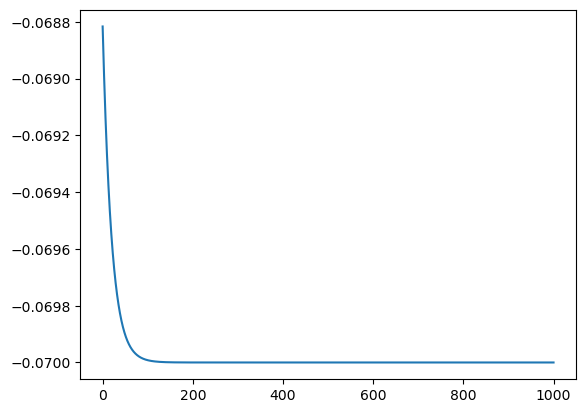

In [22]:
plt.plot(M.t/b2.ms, M.v[0], label='Neuron 0')


In [19]:
M = SpikeMonitor(excit_pop_A)


#M = SpikeMonitor(G)
# Store the current state of the network
net = b2.Network(SGG, excit_pop_A, syn_AMPA_A2A, M)
net.store()
output_rates = []
for tau in range(3):
    # Restore the original state of the network
    net.restore()
    # Run it with the new value of tau
    net.run(1*b2.second)
    output_rates.append(M.num_spikes/b2.second)


NameError: name 'plot' is not defined

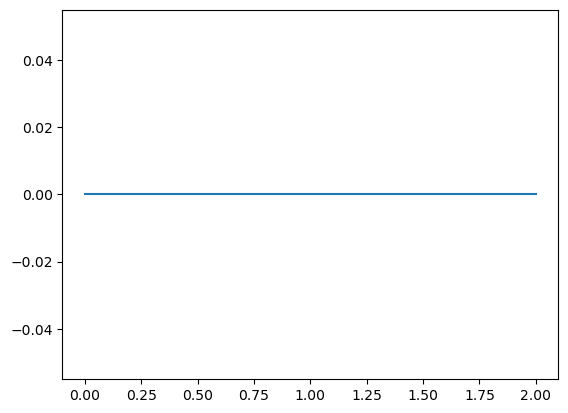

In [22]:
plt.plot(output_rates)


In [31]:
net = b2.Network(SGG, excit_pop_A, syn_AMPA_A2A, M)


In [60]:
b2.run(1*b2.second)

WARNING    "synapses_1" has been included in the network but not the object on which it depends.Setting "synapses_1" to inactive. [brian2.core.magic.dependency_warning]


In [41]:
M = SpikeMonitor(excit_pop_A)



In [42]:
M

<SpikeMonitor, recording from spikemonitor_2>

In [43]:
def get_monitors(pop, monitored_subset_size):
    """
    Internal helper.
    Args:
        pop:
        monitored_subset_size:

    Returns:

    """
    monitored_subset_size = min(monitored_subset_size, pop.N)
    idx_monitored_neurons = sample(range(pop.N), monitored_subset_size)
    rate_monitor = PopulationRateMonitor(pop)
    # record parameter: record=idx_monitored_neurons is not supported???
    spike_monitor = SpikeMonitor(pop, record=idx_monitored_neurons)
    voltage_monitor = StateMonitor(pop, "v", record=idx_monitored_neurons)
    return rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons

In [44]:
rate_monitor_A, spike_monitor_A, voltage_monitor_A, idx_monitored_neurons_A = \
        get_monitors(excit_pop_A, monitored_subset_size)


In [45]:
plot(statemon.t/ms, statemon.v[0])


NameError: name 'plot' is not defined

In [46]:
M.t

<spikemonitor_2.t: array([], dtype=float64) * second>